### This notebook creates the csv to train for milestone 2
 - it only contains oakland meters
 - it ignores mobile transactions
 - it makes a reasonably ignorant assumption about capacity of a meter, as is explained in following code chunks
 
# IT IS DUCKTAPED TOGETHER AND UNSUSTAINABLE BECAUSE PANDAS SUCKS AT KEEPING TRACK OF TIME

In [9]:
import pandas as pd
import math
import numpy as np
import datetime
import time
from pandas.tseries.holiday import USFederalHolidayCalendar as calendar
import os

In [2]:
#create a base dataframe for a zone containing: start | day_of_week | date | time
start = '2018-01-01 00:00'
end = '2018-12-31 23:50'

#tz is VERY IMPORTANT or else daylight savings will ruin your day
dr = pd.date_range(start=start, end=end, freq='10min', tz='US/Eastern')
buckets = dr.to_frame(index=False, name='start')

buckets['start'] = pd.to_datetime(buckets['start'])
buckets['day_of_week'] = buckets['start'].dt.day_name()
buckets['date'] = buckets['start'].dt.strftime('%Y-%m-%d')
buckets['month'] = buckets['start'].dt.strftime('%m')
buckets['time'] = buckets['start'].dt.time

cal = calendar()
holidays = cal.holidays('2018-01-01', '2018-12-31')
buckets['is_holiday'] = pd.to_datetime(buckets['date']).dt.date.astype('datetime64').isin(holidays)

buckets

,start,day_of_week,date,month,time,is_holiday
0,2018-01-01 00:00:00-05:00,Monday,2018-01-01,01,00:00:00,True
1,2018-01-01 00:10:00-05:00,Monday,2018-01-01,01,00:10:00,True
2,2018-01-01 00:20:00-05:00,Monday,2018-01-01,01,00:20:00,True
3,2018-01-01 00:30:00-05:00,Monday,2018-01-01,01,00:30:00,True
4,2018-01-01 00:40:00-05:00,Monday,2018-01-01,01,00:40:00,True
...,...,...,...,...,...,...
52555,2018-12-31 23:10:00-05:00,Monday,2018-12-31,12,23:10:00,False
52556,2018-12-31 23:20:00-05:00,Monday,2018-12-31,12,23:20:00,False
52557,2018-12-31 23:30:00-05:00,Monday,2018-12-31,12,23:30:00,False
52558,2018-12-31 23:40:00-05:00,Monday,2018-12-31,12,23:40:00,False


In [4]:
#Step 1: determine a fake capacity for each meter by taking the max value of cars parked over all yearly buckets
meter_df = pd.read_csv("../data/meters.csv")
meter_dict = {}

oakland_zones = [
    '407 - Oakland 1',
    '408 - Oakland 2',
    '409 - Oakland 3',
    '410 - Oakland 4'
]

for index, row in meter_df.iterrows():
    if row['status'] != 'Active':
        #Step 1a: make sure the meter is active
        continue
    
    meter = row['id']
    if meter[0] == 'P':
        #Step 1b: exclude mobile transactions
        continue
    zone = row['zone']
    if zone not in oakland_zones:
        #Step 1c: exclude non Oakland zones
        continue
        
    file_name = '../data/meter_occupancies/' + zone.replace('/','') + '/' + meter.replace('/', '') + '.csv'
    
    df = pd.read_csv(file_name)
    #Step 1d: here is our ignorant assumption about capacity: we find the max number of used spaces
    #this is ignorant because people pay for more parking than they use, as discovered by the 
    #negative occupancies in zone exploration.  
    df['total_spaces'] = df['used_spaces'].max()
    df['occupancy'] = (df['used_spaces'] / df['total_spaces']).round(3)
    
    #Step 2: Add on the month and holiday to the dataframe because its not in that version of the csv file
    df['month'] = buckets['month']
    df['is_holiday'] = buckets['is_holiday']
    
    df = df[['meter', 'zone', 'day_of_week', 'start', 'month', 'time', 'is_holiday', 'occupancy']]
    meter_dict[meter] = df

In [5]:
all_meters = pd.concat(meter_dict.values(), ignore_index = True, keys=None)
all_meters = all_meters.sort_values(by='start')
all_meters

,meter,zone,day_of_week,start,month,time,is_holiday,occupancy
0,409242-NDTHRG0106,409 - Oakland 3,Monday,2018-01-01 00:00:00-05:00,01,00:00:00,True,0.0
5256000,408230-FORBES3903,408 - Oakland 2,Monday,2018-01-01 00:00:00-05:00,01,00:00:00,True,0.0
2838240,408235-SBQUET0202,408 - Oakland 2,Monday,2018-01-01 00:00:00-05:00,01,00:00:00,True,0.0
840960,409301-FILMOR4401,409 - Oakland 3,Monday,2018-01-01 00:00:00-05:00,01,00:00:00,True,0.0
7989120,409256-SCRAIG0301,409 - Oakland 3,Monday,2018-01-01 00:00:00-05:00,01,00:00:00,True,0.0
...,...,...,...,...,...,...,...,...
5939279,407136-DARAGH0306,407 - Oakland 1,Monday,2018-12-31 23:50:00-05:00,12,23:50:00,False,0.0
5886719,409294-NBLFLD0202,409 - Oakland 3,Monday,2018-12-31 23:50:00-05:00,12,23:50:00,False,0.0
5834159,409286-TNYSON0101,409 - Oakland 3,Monday,2018-12-31 23:50:00-05:00,12,23:50:00,False,0.0
6254639,409252-NCRAIG0108,409 - Oakland 3,Monday,2018-12-31 23:50:00-05:00,12,23:50:00,False,0.0


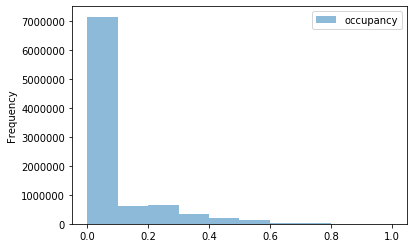

In [6]:
#checking distribution of occupancy
occ = pd.DataFrame(all_meters['occupancy'])
ax = occ.plot.hist(bins=10, alpha=0.5)

In [7]:
all_meters.to_csv('../data/OAKLAND_meter_nonmobile_occupancies.csv', index=False)

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':


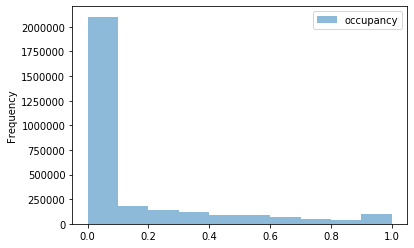

In [13]:
zone_dict = {}
for root, dirs, files in os.walk('../data/zone_occupancies'):
    for file in files:
        df = pd.read_csv('../data/zone_occupancies' + '/' + file)
        df['occupancy'] = 1 - (df['free_spaces']/df['total_spaces'])
      
        zone_dict[file] = df
        
all_zones = pd.concat(zone_dict.values(), ignore_index = True, keys=None)

temp = all_zones['occupancy']
temp[temp > 1] = 1
all_zones['occupancy'] = temp


occ = pd.DataFrame(all_zones['occupancy'])
ax = occ.plot.hist(bins=10, alpha=0.5)